### Phase 1 - Problem Definition  
#### 1.1 Broad Goals  

The purpose of this study is to identify fraudulent transactions in an extremely unbalanced dataset.  

#### 1.2 Data Source

The data is courtesy of the PaySim synthetic dataset available on Kaggle.  
https://www.kaggle.com/ntnu-testimon/paysim1

"PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world."

The kaggle dataset is scaled back to 1/4 the size of the original and simulates 30 days of mobile money transactions.

#### 1.3 Problem Statement 

### Phase 2 - Data Gathering  
#### 2.1 Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### 2.2 Load Data

In [2]:
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

In [3]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [4]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
# to make all columns camel case and labeled the same way

### Phase 3 - Exploratory Data Analysis  
#### 3.1 Dataset Shape

In [5]:
df.shape

(6362620, 11)

#### 3.2 Fraud by Transaction Type

In [6]:
df['isFlaggedFraud'].value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

In [7]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Okay, we're dealing with a very imbalanced group here.  That means we'll either need to correct the class imbalance or we'll have an extremely high bar to improve on.

In [8]:
df.groupby(by = ['type'])['isFraud'].value_counts()

type      isFraud
CASH_IN   0          1399284
CASH_OUT  0          2233384
          1             4116
DEBIT     0            41432
PAYMENT   0          2151495
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

At the moment we're ONLY seeing fraud samples in the CASH_OUT and TRANSFER categories.  We might be able to narrow our field of vision to focus on only these two categories.

In [9]:
is_co = df[df['type'] == 'CASH_OUT']
is_tr = df[df['type'] == 'TRANSFER']
is_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237500 entries, 3 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 204.8+ MB


In [10]:
cot_df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

In [11]:
cot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 253.6+ MB


In [12]:
cot_df.groupby(by = ['type'])['isFraud'].value_counts()

type      isFraud
CASH_OUT  0          2233384
          1             4116
TRANSFER  0           528812
          1             4097
Name: isFraud, dtype: int64

In [13]:
cot_df['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [14]:
cot_df['isFraud'].value_counts(normalize = True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

Even in the categories that have confirmed fraud, we're only seeing 8.2k samples of fraud out of 2.7m samples.  Still a highly unbalanced class, although we've improved the positively identified cases from 0.13 % to 0.3 %.  This means that our baseline for our target column will need to be better than 99.7% accurate.  Let's see if we can improve on that.

In [16]:
df.groupby('nameDest')['isFraud'].value_counts(sort = True)

nameDest     isFraud
C1000004082  0           6
C1000004940  0          13
C1000013769  0          13
C100001587   0           9
C1000015936  0          16
                        ..
M999998692   0           1
M99999900    0           1
M999999089   0           1
M999999543   0           1
M999999784   0           1
Name: isFraud, Length: 2727854, dtype: int64

In [17]:
df.groupby('isFraud')['nameDest'].value_counts()

isFraud  nameDest   
0        C1286084959    113
         C985934102     109
         C665576141     105
         C2083562754    102
         C1590550415    101
                       ... 
1        C998514614       1
         C999409522       1
         C999470580       1
         C999708230       1
         C999955448       1
Name: nameDest, Length: 2727854, dtype: int64

In [18]:
fraud = df[df['isFraud']== 1]

In [19]:
fraud['nameDest'].value_counts()

C104038589     2
C1981613973    2
C643624257     2
C1780714769    2
C1650668671    2
              ..
C870195127     1
C1072954107    1
C583506611     1
C363499391     1
C183363284     1
Name: nameDest, Length: 8169, dtype: int64

In [20]:
fraud['nameOrig'].value_counts()

C874465366     1
C1882162040    1
C875187668     1
C1328487364    1
C1454479269    1
              ..
C417066150     1
C1587485060    1
C1551381510    1
C313989858     1
C415054779     1
Name: nameOrig, Length: 8213, dtype: int64

The destination accounts for fraud transactions occasionally have some overlap, the origin accounts do not.

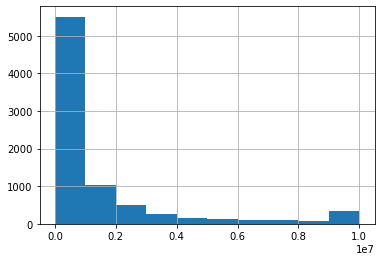

In [22]:
fraud['amount'].hist()

Text(0.5, 1.0, 'Count of Fraudulent Transacitons per Time Step')

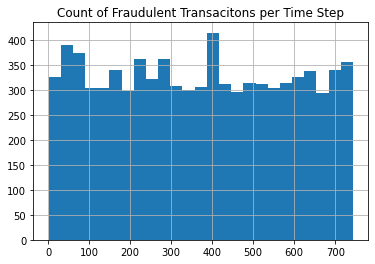

In [32]:
fraud['step'].hist(bins = 25)
plt.title("Count of Fraudulent Transacitons per Time Step")

Text(0.5, 1.0, 'Count of Transactions per Time Step')

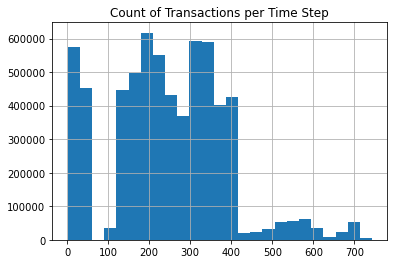

In [33]:
df['step'].hist(bins = 25)
plt.title("Count of Transactions per Time Step")

While we're seeing a bit of a spike in fraudulent transactions around the 400th hour of the time frame, the number of fraudulent transactions remains constant.  Interestingly, we're also seeing a dramatic dropoff in total transactions around that same timeframe.  Maybe we can look at percentage of fraud over time.

In [70]:
time_fraud = df.groupby('step').agg({'isFraud': 'sum'}, axis = 1)

In [62]:
time_fraud

,isFraud
step,
1,16
2,8
3,4
4,10
5,6
...,...
739,10
740,6
741,22


Text(0.5, 1.0, 'Amount of Fraudulent Transactions per Timestep')

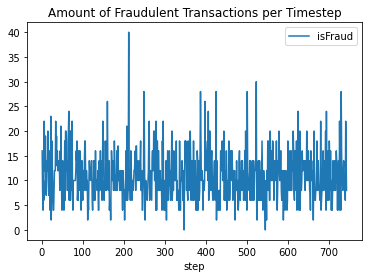

In [64]:
time_fraud.plot()
plt.title("Amount of Fraudulent Transactions per Timestep")

In [75]:
df['step']

KeyError: 1

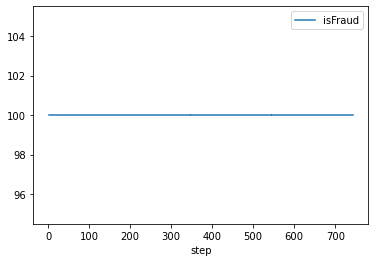